# Analysis of results with `MiniGridEnv`

This notebook explores and visualize the results on `MiniGridEnv` adopting different strategies:
1. random action policy
2. market-only policy
3. battery-first policy
4. 20/80 policy
5. 50/50 policy
6. training a PPO agent with StableBaselines3 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/Users/dave/Library/CloudStorage/OneDrive-PolitecnicodiMilano/PhD/Repositories/ernesto-gym


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm 
from datetime import datetime
import os
import orjson as json
from pathlib import Path
from collections import OrderedDict

from ernestogym.envs import MicroGridEnv
from ernestogym.envs.single_agent.utils import parameter_generator

sns.set_style('darkgrid')
plot_colors = sns.color_palette()
sns.set(font_scale=1.5)

plots_dir = 'examples/single_agent/plots'
os.makedirs(plots_dir, exist_ok=True)

In [10]:
alg_color = OrderedDict({
    'random': plot_colors[0],
    'only_market': plot_colors[1],
    'battery_first': plot_colors[2],
    '20-80': plot_colors[3],
    '50-50': plot_colors[4],
    'ppo': plot_colors[5],
    'a2c': plot_colors[6],
    'sac': plot_colors[7]
})

alg_markers = OrderedDict({
    'random': '.',
    'only_market': 'o',
    'battery_first': 'v',
    '20-80': 's',
    '50-50': 'P',
    'ppo': '*',
    'a2c': '+',
    'sac': '<'
})

In [91]:
exp_name = "rev3_final_noclip"
folder = "./logs/{}/results/".format(exp_name)

do_not_save = False

In [92]:
algs = [f for f in alg_color.keys() if f in os.listdir(folder)]

In [93]:
#algs.remove('random')
#algs.remove('battery_first')
#algs.remove('50-50')
#algs.remove('20-80')

In [94]:
algs

['random', 'only_market', 'battery_first', '20-80', '50-50', 'ppo', 'a2c']

In [95]:
def load_results(alg:str):

    alg_res = []

    results_folder = folder + alg +'/'
    tests_files = [f for f in os.listdir(results_folder)]

    for file in tqdm(tests_files):
        f = open (results_folder + file, "r")
        data = json.loads(f.read())
        alg_res.append(data)

    return alg_res

In [96]:
res_dict = {}

for alg in algs:
    res_dict[alg] = load_results(alg)

100%|█████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.68s/it]


In [97]:
timestamps = pd.read_csv("ernestogym/ernesto/data/demand/dataset.csv", usecols=['timestamp'])['timestamp'].values.tolist()

In [98]:
timestamps = [datetime.strptime(time, "%Y-%m-%d %H:%M:%S") for time in timestamps]

In [99]:
algs

['random', 'only_market', 'battery_first', '20-80', '50-50', 'ppo', 'a2c']

In [100]:
alg_names = {
    'a2c': 'A2C',
    'battery_first': 'Battery-first',
    '20-80': '20-80',
    'random': 'Random',
    'ppo': 'PPO',
    '50-50': '50-50',
    'only_market': 'Only-market',
    'sac': 'SAC'
}

In [101]:
def savefig(fig: plt.Figure, filename: str, **kwargs) -> None:
    if not do_not_save:
        save_path = os.path.join(plots_dir, filename)
        fig.savefig(save_path, dpi=300, bbox_inches='tight', **kwargs)

In [102]:
res_dict['ppo'][1].keys()

dict_keys(['test', 'pure_reward', 'norm_reward', 'weighted_reward', 'total_reward', 'actions', 'states'])

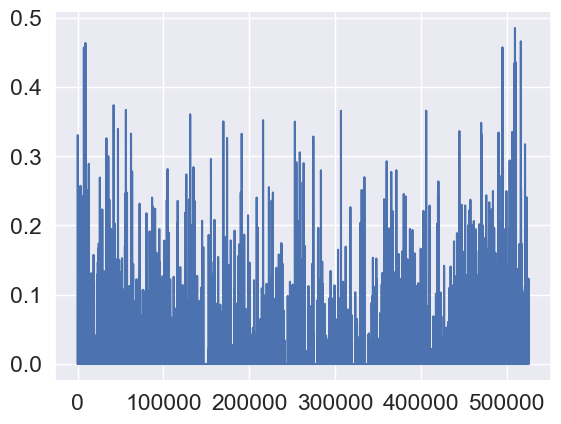

In [103]:
plt.plot(res_dict['ppo'][1]['actions'])

In [104]:
#plt.plot(res_dict['random'][1]['actions'])

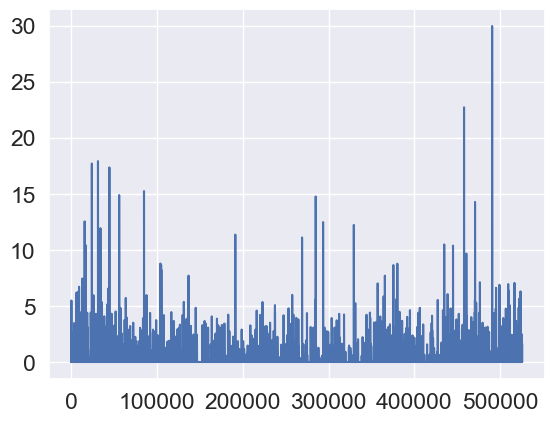

In [105]:
plt.plot(res_dict['ppo'][1]['pure_reward']['r_op'])

In [106]:
#plt.plot(res_dict['only_market'][1]['norm_reward']['r_trad'])

In [107]:
3000 / (60 * 0.8 * (0.9 * 3000 - 0.1))

0.023149005518722912

## PLOTS

In [108]:
# Average return across all the test experiments throw boxplots
def average_return(r_type:str = 'norm_reward'):
    data = {}
    colors = []
    
    for alg in algs:
        if r_type == 'weighted_reward':
            data[alg_names[alg]] = [res_dict[alg][i]['total_reward'] for i in range(len(res_dict[alg]))]
        else:
            data[alg_names[alg]] = [sum(res_dict[alg][i][r_type]['r_trad']) - 
                                    sum(res_dict[alg][i][r_type]['r_op']) - 
                                    sum(res_dict[alg][i][r_type]['r_clip'])
                                    for i in range(len(res_dict[alg]))]
        colors.append(alg_color[alg])
            
    fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
    box_plot = sns.boxplot(data, gap=.1, palette=colors)
    
    medians = [np.mean(values) for key, values in data.items()]
    vertical_offset = 1000 # offset from median for display

    for xtick, alg in zip(box_plot.get_xticks(), algs):
        box_plot.text(xtick, vertical_offset, round(medians[xtick]), 
                      horizontalalignment='center',size='x-small', color=alg_color[alg], weight='semibold')
    
    print({key: np.mean(values) for key, values in data.items()})    
    
    savefig(fig, filename='{}-average_return.pdf'.format(exp_name))
    savefig(fig, filename='{}-average_return.png'.format(exp_name))
    
    return data

{'Random': -21480.394417550713, 'Only-market': -6225.3626515519045, 'Battery-first': -40791.01634361944, '20-80': -11837.28074872894, '50-50': -21461.801883986052, 'PPO': -6220.7872965693605, 'A2C': -39774.158847025334}


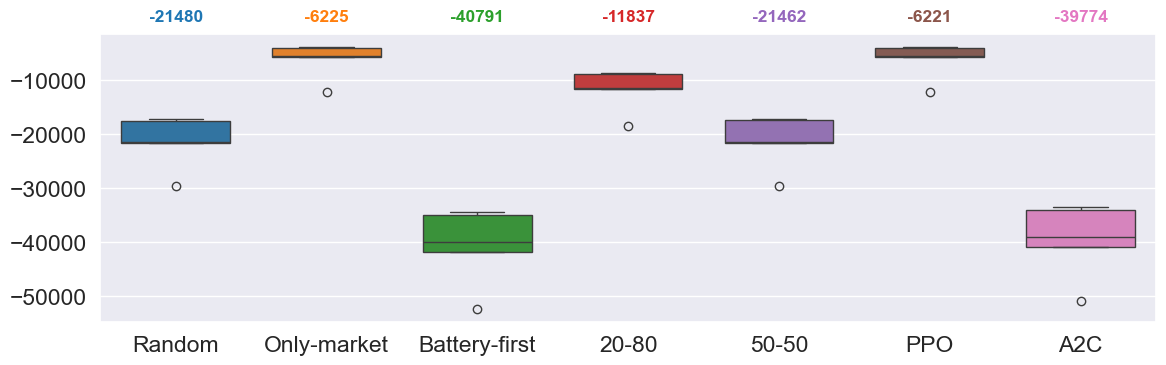

In [109]:
df = pd.DataFrame.from_dict(average_return(r_type='norm_reward'))

In [110]:
df.describe()

,Random,Only-market,Battery-first,20-80,50-50,PPO,A2C
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-21480.394418,-6225.362652,-40791.016344,-11837.280749,-21461.801884,-6220.787297,-39774.158847
std,4994.358505,3457.482605,7237.217509,3976.326982,5064.647501,3458.490798,7046.304942
min,-29571.189479,-12226.373511,-52396.037628,-18528.593760,-29664.957623,-12223.383111,-51065.203317
25%,-21674.617941,-5678.614924,-41964.292956,-11581.702516,-21663.756725,-5673.045954,-40905.795852
50%,-21468.448049,-5430.083102,-40074.075424,-11440.412540,-21449.853668,-5427.125494,-39120.694269
75%,-17507.832905,-3996.234853,-35079.713581,-8902.274703,-17419.067081,-3990.688985,-34162.604118
max,-17179.883713,-3795.506868,-34440.962129,-8733.420224,-17111.374322,-3789.692939,-33616.496678


In [111]:
def cum_average_reward_terms_comparison(sampling_rate=10, reward_type='weighted_reward'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Time', ylabel='Avg. Trading Reward', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Time', ylabel='Avg. Operational Cost', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Time', ylabel='Avg. Action Clipping', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='{}-avg_cum_terms_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_{}.png'.format(exp_name, reward_type))

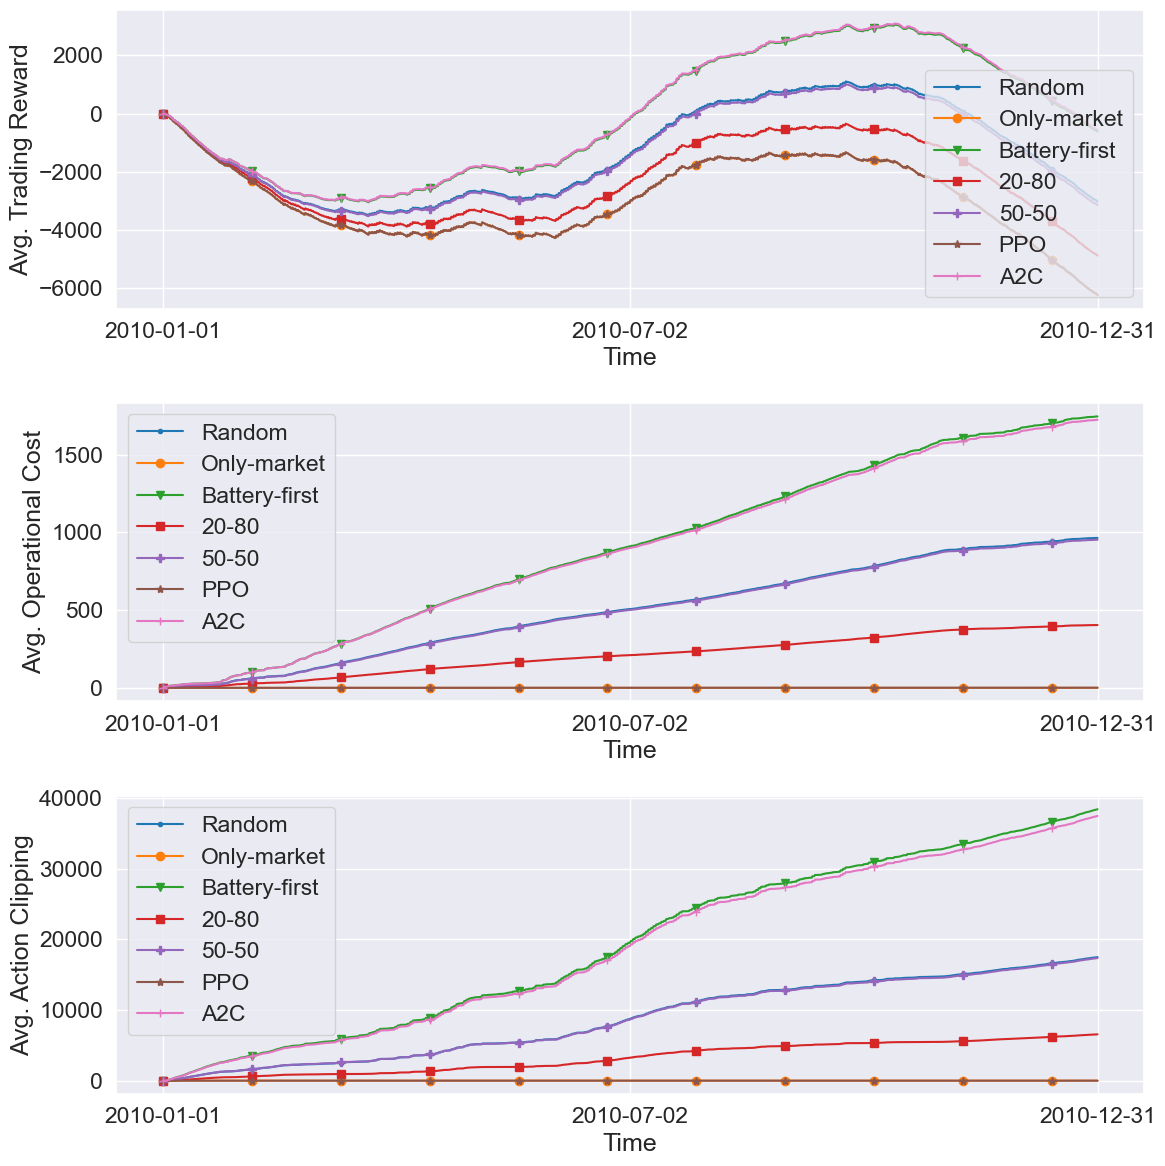

In [112]:
cum_average_reward_terms_comparison(reward_type='norm_reward')

In [113]:
def average_total_reward_with_baseline(sampling_rate=10, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ax = plt.subplots(figsize=(12, 4), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    baseline_reward = np.cumsum(np.sum([trad_means, op_means * -1, clip_means * -1], axis=0))
    
    for i, alg in enumerate(algs):
        trad_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)
        total_reward = np.cumsum(np.sum([trad_means, op_means * -1, clip_means * -1], axis=0))
        
        ax.plot(timestamps[::sampling_rate], (total_reward - baseline_reward)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax.set(xlabel='Time', ylabel="Delta cum. reward", xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax.legend()
    
    savefig(fig, filename='{}-avg_cum_reward_with_baseline_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_reward_with_baseline_{}.png'.format(exp_name, reward_type))

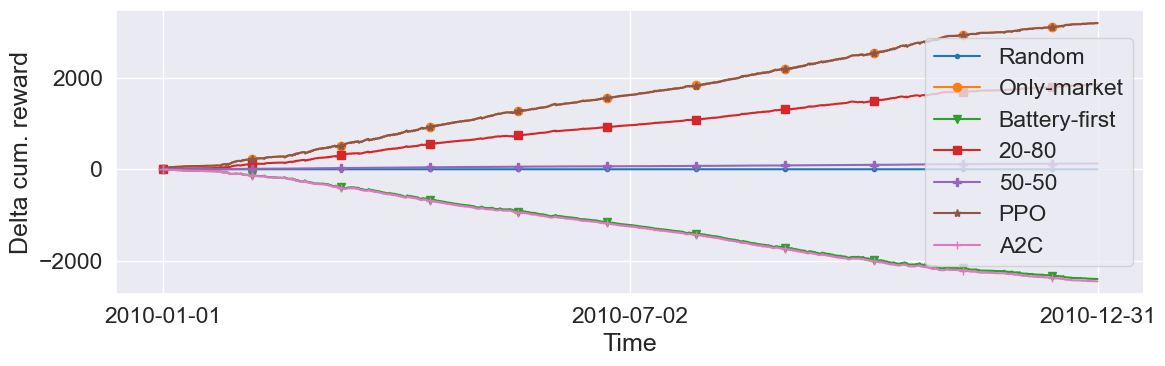

In [114]:
average_total_reward_with_baseline(reward_type='norm_reward', baseline='random')

In [115]:
def cum_average_reward_terms_with_baseline(sampling_rate=10, reward_type='weighted_reward', baseline='20-80'):
    data = {}
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(12, 12), tight_layout=True)
    
    trad_means = np.mean([res_dict[baseline][i][reward_type]['r_trad'] for i in range(len(res_dict[baseline]))], axis=0)     
    op_means = np.mean([res_dict[baseline][i][reward_type]['r_op'] for i in range(len(res_dict[baseline]))], axis=0)     
    clip_means = np.mean([res_dict[baseline][i][reward_type]['r_clip'] for i in range(len(res_dict[baseline]))], axis=0)     
    
    for i, alg in enumerate(algs):
        means = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        ax1.plot(timestamps[::sampling_rate], np.cumsum(means - trad_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax1.set(xlabel='Time', ylabel='Delta cum. R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         
        ax1.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)
        ax2.plot(timestamps[::sampling_rate], np.cumsum(means - op_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax2.set(xlabel='Time', ylabel='Delta cum. R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax2.legend()
        
        means = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)
        ax3.plot(timestamps[::sampling_rate], np.cumsum(means - clip_means)[::sampling_rate], label=alg_names[alg], color=alg_color[alg], marker=alg_markers[alg], markevery=5000)
        ax3.set(xlabel='Time', ylabel='Delta cum. R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 
        ax3.legend()
        
    savefig(fig, filename='{}-avg_cum_terms_with_baseline_{}.pdf'.format(exp_name, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_with_baseline_{}.png'.format(exp_name, reward_type))

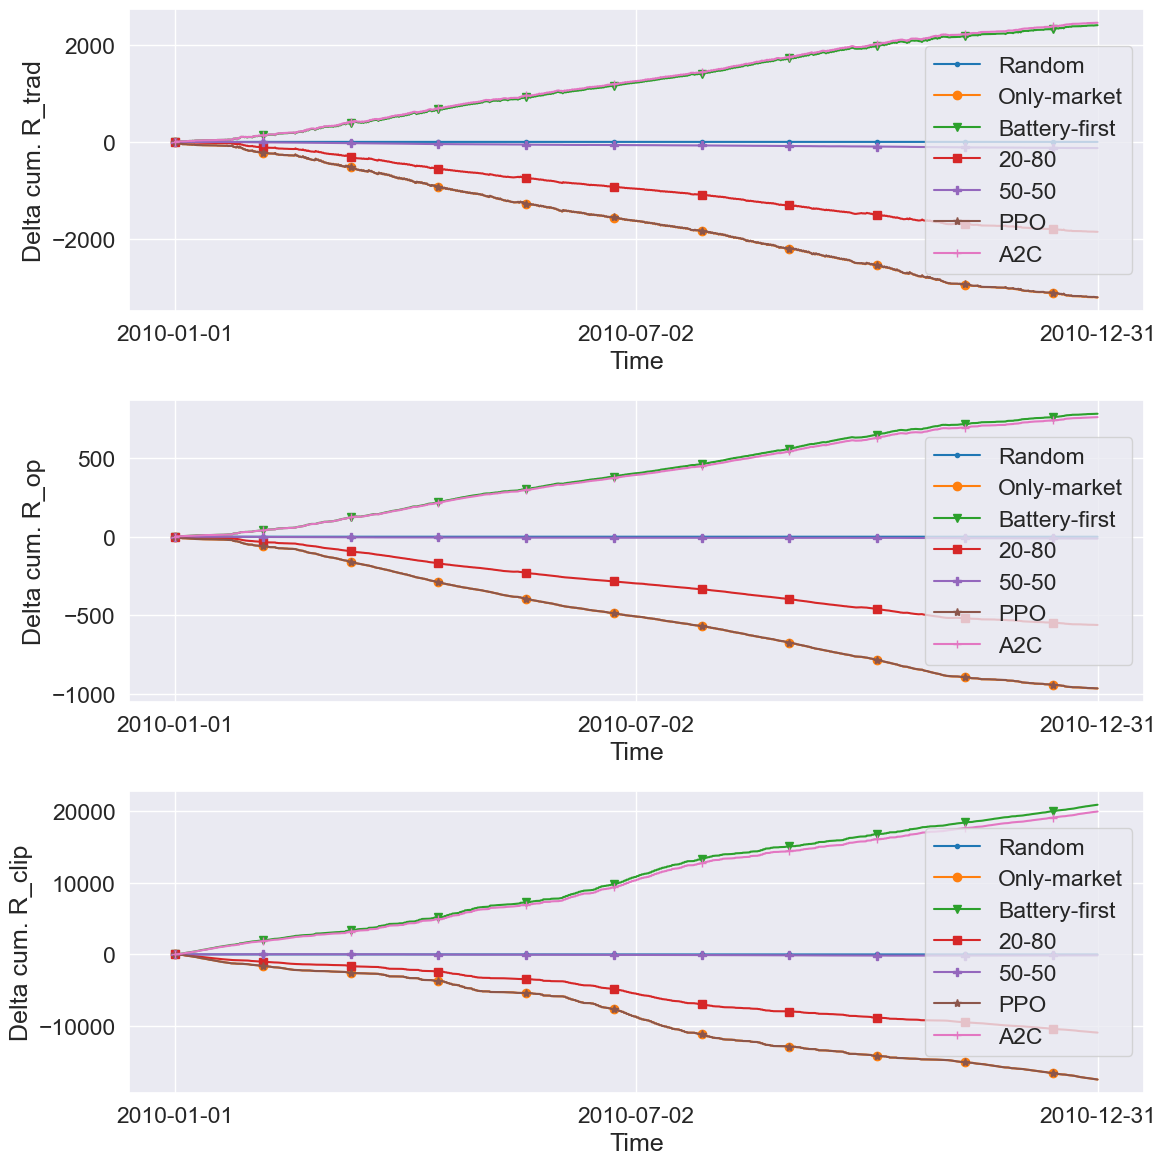

In [116]:
cum_average_reward_terms_with_baseline(reward_type='norm_reward', baseline='random')

In [117]:
def single_policy_reward_terms(alg, reward_type='weighted_reward', test='', sampling_rate=10):    
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3, 1, figsize=(9, 12), tight_layout=True)
    
    if not test:
        trad_list = np.mean([res_dict[alg][i][reward_type]['r_trad'] for i in range(len(res_dict[alg]))], axis=0)     
        op_list = np.mean([res_dict[alg][i][reward_type]['r_op'] for i in range(len(res_dict[alg]))], axis=0)     
        clip_list = np.mean([res_dict[alg][i][reward_type]['r_clip'] for i in range(len(res_dict[alg]))], axis=0)     
    else:
        idx = [i for i in range(len(res_dict[alg])) if test == res_dict[alg][i]['test']][0]
        trad_list = res_dict[alg][idx][reward_type]['r_trad']   
        op_list = res_dict[alg][idx][reward_type]['r_op']     
        clip_list = res_dict[alg][idx][reward_type]['r_clip']     
    
    ax1.plot(timestamps[::sampling_rate], trad_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax1.set(xlabel='Time', ylabel='R_trad', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])         

    ax2.plot(timestamps[::sampling_rate], op_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax2.set(xlabel='Time', ylabel='R_op', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]]) 

    ax3.plot(timestamps[::sampling_rate], clip_list[::sampling_rate], label=alg_names[alg], color=alg_color[alg])
    ax3.set(xlabel='Time', ylabel='R_clip', xticks=[timestamps[0], timestamps[len(timestamps)//2], timestamps[-1]])
    
    savefig(fig, filename='{}-avg_cum_terms_{}_{}.pdf'.format(exp_name, alg, reward_type))
    savefig(fig, filename='{}-avg_cum_terms_{}_{}.png'.format(exp_name, alg, reward_type))

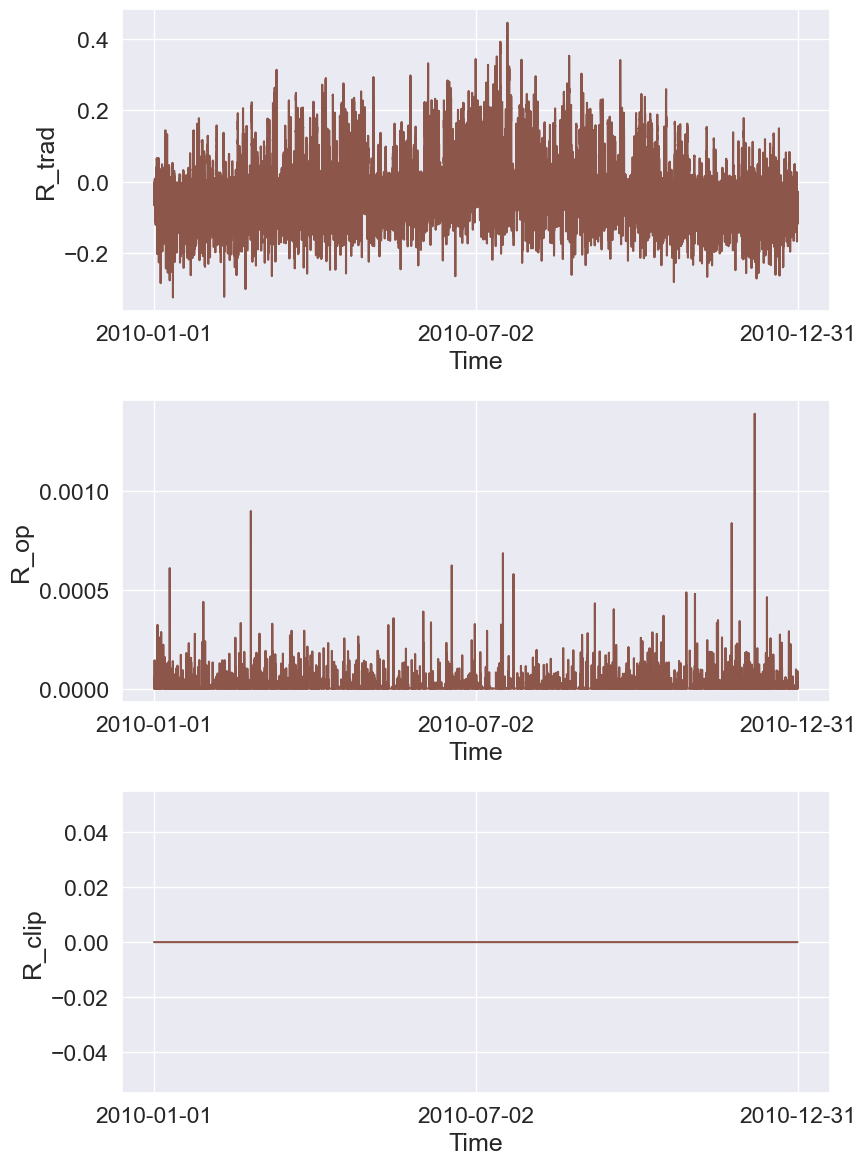

In [118]:
single_policy_reward_terms(alg='ppo', reward_type='norm_reward', test='')

In [ ]:
demand = pd.read_csv("ernestogym/ernesto/data/demand/dataset.csv")
generation = pd.read_csv("ernestogym/ernesto/data/generation/pv_dataset.csv")

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(9, 12), tight_layout=True)

sampling_rate = 500
timestamps = demand['timestamp'].values.tolist()

axs[0].plot(timestamps[::sampling_rate], np.cumsum(demand['70'][::sampling_rate]), label='demand')
axs[0].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[0].set(xlabel='Time', ylabel='70', xticks=[timestamps[0], timestamps[-1]])
axs[0].legend()

axs[1].plot(timestamps[::sampling_rate], np.cumsum(demand['71'][::sampling_rate]), label='demand')
axs[1].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[1].set(xlabel='Time', ylabel='71', xticks=[timestamps[0], timestamps[-1]])
axs[1].legend()

axs[2].plot(timestamps[::sampling_rate], np.cumsum(demand['72'][::sampling_rate]), label='demand')
axs[2].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[2].set(xlabel='Time', ylabel='72', xticks=[timestamps[0], timestamps[-1]])
axs[2].legend()

axs[3].plot(timestamps[::sampling_rate], np.cumsum(demand['73'][::sampling_rate]), label='demand')
axs[3].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[3].set(xlabel='Time', ylabel='73', xticks=[timestamps[0], timestamps[-1]])
axs[3].legend()

axs[4].plot(timestamps[::sampling_rate], np.cumsum(demand['74'][::sampling_rate]), label='demand')
axs[4].plot(timestamps[::sampling_rate], np.cumsum(generation['PV'][::sampling_rate]), label='gen')
axs[4].set(xlabel='Time', ylabel='74', xticks=[timestamps[0], timestamps[-1]])
axs[4].legend()